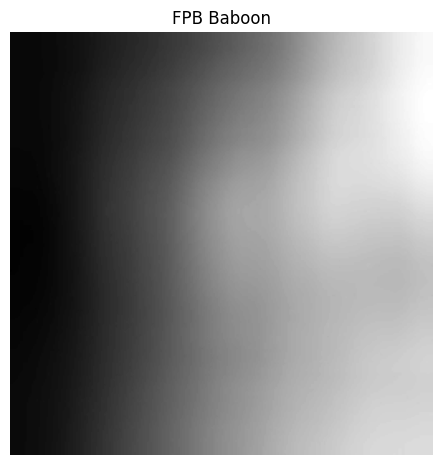

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy.stats import multivariate_normal
%matplotlib inline

# leer la imagen de Baboo original
imagen_original = mpimg.imread("C:/Users/luisl/OneDrive/Escritorio/PDI/Estancia Investigacion/Recursos/baboon.jpg")
# Debemos cumplir con la siguiente formula g(x,y) = f(x,y)h(x,y)+n(x)
# Convertir la imagen de Baboo original a escala de grises. Ésta será nuestra f(x,y)
imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_RGB2GRAY)
imagen_con_ruido = mpimg.imread("C:/Users/luisl/OneDrive/Escritorio/PDI/Estancia Investigacion/Recursos/imagen_con_ruido.jpg")
# Leer las h estimadas
FPB_Baboon = mpimg.imread("C:/Users/luisl/OneDrive/Escritorio/PDI/Estancia Investigacion/Recursos/FPB_Baboon_Gradiente_Iluminacion.jpg")

# Calcular histogramas
histograma_FPB_Baboon = cv2.calcHist([FPB_Baboon], [0], None, [256], [0, 256])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(FPB_Baboon, cmap="gray")
plt.title("FPB Baboon")
plt.axis('off')
         
plt.show()

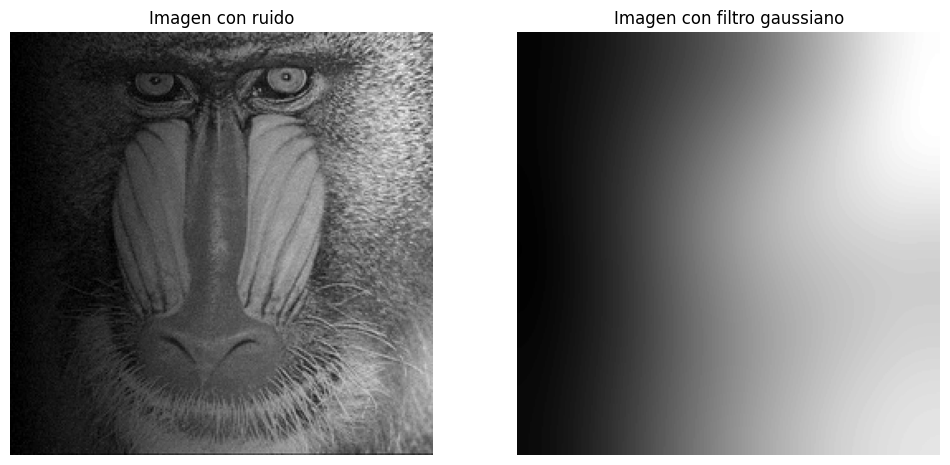

In [3]:
sigma = 250
size = 71

imagen_filtrada = cv2.GaussianBlur(FPB_Baboon, (size, size), sigma)

#cv2.imwrite("C:/Users/luisl/OneDrive/Escritorio/PDI/Estancia Investigacion/Recursos/FG_Baboon_Gradiente_Iluminacion.jpg", imagen_filtrada)

# Creamos una figura para contener ambas subtramas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagen_con_ruido, cmap="gray")
plt.title("Imagen con ruido")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagen_filtrada, cmap="gray")
plt.title("Imagen con filtro gaussiano")
plt.axis('off')


plt.show()

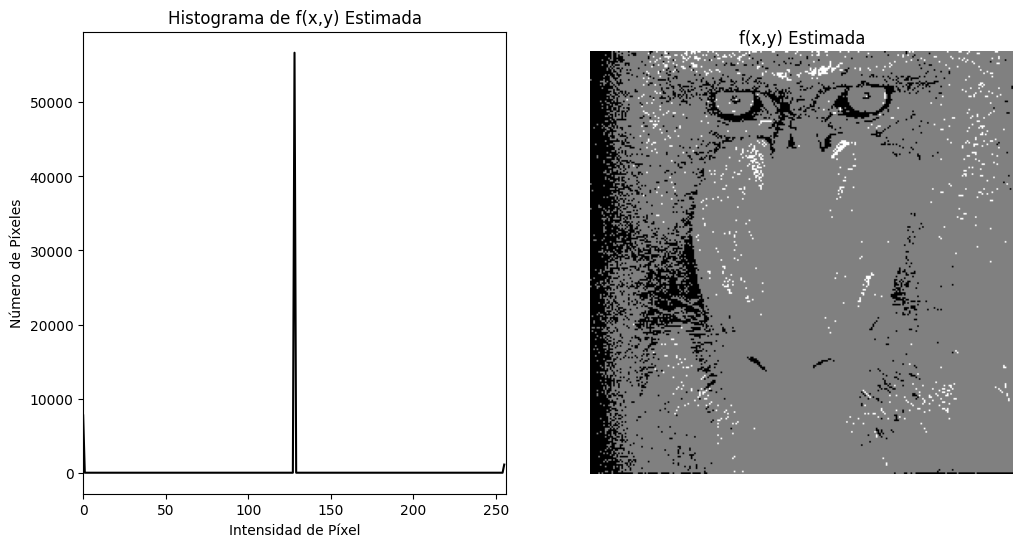

In [4]:
# Una vez que tenemos nuestra h_estimada(x,y) procederemos a obtener nuestra f_estimada(x,y). Para obtener f_estimada(x,y) vamos a realizar una división de nuestra g(x,y)/h_estimada(x,y)



# Se realiza la divisón de g(x,y) entre la h_estimada(x,y) para obtener la f_estimada(x,y)
f_estimada = cv2.divide(imagen_con_ruido,imagen_filtrada).astype(np.float32)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(f_estimada)
f_estimada = cv2.convertScaleAbs(f_estimada, alpha=255.0/(max_val - min_val), beta=-min_val * 255.0/(max_val - min_val))

# Calcular el histograma de f_estimada_scaled
histograma_f_estimada = cv2.calcHist([f_estimada], [0], None, [256], [0, 256])
#cv2.imwrite("C:/Users/luisl/OneDrive/Escritorio/PDI/Estancia Investigacion/Recursos/FG_Baboon_Gradiente_fEstimada.jpg", f_estimada)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(histograma_f_estimada, color='black')
plt.title("Histograma de f(x,y) Estimada")
plt.xlabel("Intensidad de Píxel")
plt.ylabel("Número de Píxeles")
plt.xlim([0, 256])

plt.subplot(1, 2, 2)
plt.imshow(f_estimada, cmap="gray")
plt.title("f(x,y) Estimada")
plt.axis('off')

plt.show()

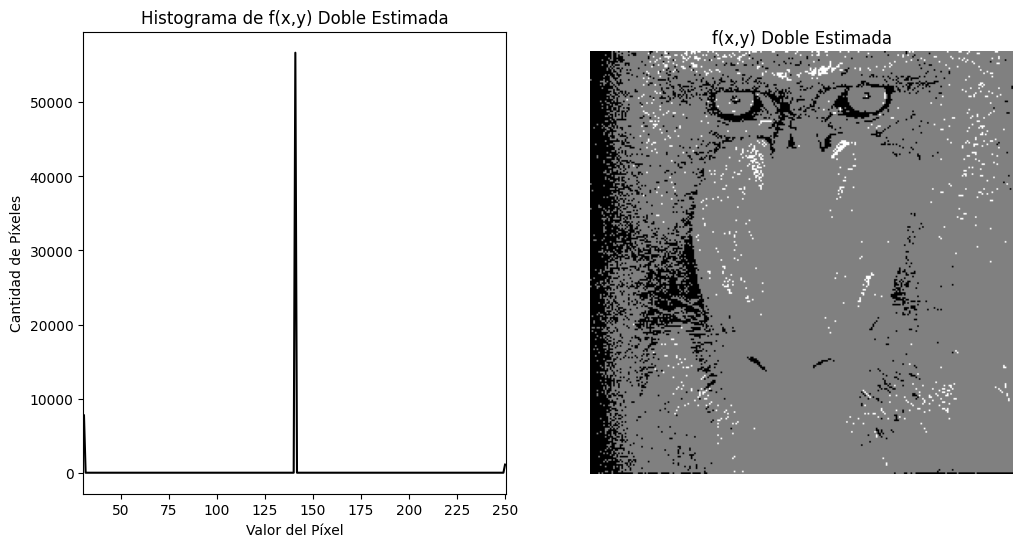

In [5]:
# A continuación realiazremos una normalización de nuestra f_estimada utilizando la media y desviación estandar de nuestra f(x,y)



# Se calcula la media y desviación estandar de g(x,y)
media_observada, desviacionEstandar_observada = cv2.meanStdDev(imagen_gris)

#print(f"Media g(x,y): {media_observada[0][0]}")
#print(f"Desviación estándar g(x,y): {desviacionEstandar_observada[0][0]} \n\n")

# Se calcula la media y desviación estandar de f(x,y) estimada
media_fEstimada, desviacionEstandar_fEstimada = cv2.meanStdDev(f_estimada)

#print(f"Media f(x,y) estimada: {media_pruebaUno[0][0]}")
#print(f"Desviación f(x,y) estimada: {desviacionEstandar_pruebaUno[0][0]}")

f_dobleEstimada = ((f_estimada - media_fEstimada) / desviacionEstandar_fEstimada) * desviacionEstandar_observada + media_observada

#print(f"F doble estimada es {f_dobleEstimada}")

conteos, bordes_bins = np.histogram(f_dobleEstimada.flatten(), bins=256, range=[np.min(f_dobleEstimada), np.max(f_dobleEstimada)])
centros_bins = (bordes_bins[:-1] + bordes_bins[1:]) / 2

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(centros_bins, conteos, color='black')
plt.title("Histograma de f(x,y) Doble Estimada")
plt.xlabel("Valor del Píxel")
plt.ylabel("Cantidad de Píxeles")
# Ajusta los límites del eje x para que coincidan con el rango de datos de la imagen flotante
plt.xlim([np.min(f_dobleEstimada), np.max(f_dobleEstimada)])

# Ahora, muestra la imagen f_dobleEstimada en formato float64
plt.subplot(1, 2, 2)
plt.imshow(f_dobleEstimada, cmap='gray', vmin=np.min(f_dobleEstimada), vmax=np.max(f_dobleEstimada))
plt.title("f(x,y) Doble Estimada")
plt.axis('off')

plt.show()

In [6]:
# Aplicamos el RMSE como criterio de comparación

# Se calcula RMSE entre g(x,y) y f_estimada
if f_estimada.shape != imagen_gris.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño")

# Calcular la diferencia entre las imágenes
diferencia = f_dobleEstimada.astype(np.float32) - imagen_gris.astype(np.float32)

# Calcular el cuadrado de las diferencias
cuadrado_diferencias = np.square(diferencia)

# Calcular el promedio de los cuadrados de las diferencias
promedio_cuadrados = np.mean(cuadrado_diferencias)

# Tomar la raíz cuadrada del promedio para obtener el RMSE
rmse1 = np.sqrt(promedio_cuadrados)

print(f"El RMSE entre f_estimada(x,y) y g(x,y) es: {rmse1}")

# Se calcula RMSE entre g(x,y) y f_doble_estimada
if f_dobleEstimada.shape != imagen_gris.shape:
    raise ValueError("Las imágenes deben tener el mismo tamaño")

# Calcular la diferencia entre las imágenes
diferencia = f_dobleEstimada.astype(np.float32) - imagen_gris.astype(np.float32)

# Calcular el cuadrado de las diferencias
cuadrado_diferencias = np.square(diferencia)

# Calcular el promedio de los cuadrados de las diferencias
promedio_cuadrados = np.mean(cuadrado_diferencias)

# Tomar la raíz cuadrada del promedio para obtener el RMSE
rmse2 = np.sqrt(promedio_cuadrados)

print(f"El RMSE entre f_dobleEstimada(x,y) y g(x,y) es: {rmse2}")

El RMSE entre f_estimada(x,y) y g(x,y) es: 43.46371078491211
El RMSE entre f_dobleEstimada(x,y) y g(x,y) es: 43.46371078491211
